In [47]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, functions as f
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession.builder.appName('LoanAnalysis').getOrCreate()

In [2]:
def get_null_cols(df):
    null_columns_count = []
    total_rows = df.count()
    for i in df.columns:
        null_rows = df.where(f.col(i).isNull()).count()
        if null_rows > 0:
            temp = i, null_rows, (null_rows / total_rows)* 100
            null_columns_count.append(temp)
    
    spark.createDataFrame(null_columns_count, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

In [3]:
def calculate_total_rows_dropped(df):
    df_len = df.count()
    df_drop_len = df.na.drop().count()
    print('Total Rows to Be Dropped:', df_len - df_drop_len)
    print('Percentage of Rows Dropped:', (df_len - df_drop_len) / df_len)
    

In [4]:
"""
    Converts  all string data to numeric type otherwise algorithms will not be able to process it.
"""
def string_to_numeric_cols(df, input_cols):
    numeric_cols = []
    string_cols = []
    
    for column in input_cols:
        # If the input_col is StringType, rename it and map it to a new column. Apply fit() and transform()
        if str(df.schema[column].dataType) == 'StringType':
            indexer = StringIndexer(inputCol = column, outputCol = column + '_num')
            df = indexer.fit(df).transform(df) 
            new_col_name = column+ '_num' # Rename the new column to distinguish it from the old one.
            string_cols.append(new_col_name)
        # The column was already of a numeric type.
        else:
            numeric_cols.append(column)
    return [df,numeric_cols, string_cols]
    

In [5]:
"""
    Returns a dictionary with the approximate quantiles at the given probabilities. 
"""
def get_quantile_approx(input_cols, df):
    # cut off/percentages for numeric_cols
    quantiles_dict = {column: df.approxQuantile(column,[0.01,0.99],0.25) for column in input_cols}
    return quantiles_dict

    

In [6]:
def fix_skewness(df, input_cols, quantiles_dict):
    for column in input_cols:
        # f.skewness returns the skewness of the values in a group
        # skew stores a list with the column name and its skewness
        skew = df.agg(f.skewness(df[column])).collect() 
        skew_val = skew[0][0] # the numeric value of the list
        
        # If data is right skewed, then fix by applying floor, cap, or log + 1
        if skew_val >  1:
            df = df.withColumn(column, \
                              f.log(f.when(df[column] < quantiles_dict[column][0], quantiles_dict[column][0]) \
                                 .when(df[column] > quantiles_dict[column][1], quantiles_dict[column][1]) \
                                 .otherwise(df[column]) + 1) \
                               .alias(column))
            print("Right/positive skewness of", skew_val, " was fixed on column ", column)
        # If data is left skewed, then  floor, cap or exp(x)
        elif skew_val < -1:
            df = df.withColumn(column, \
                              f.exp(f.when(df[column] < quantiles_dict[column][0], quantiles_dict[column][0]) \
                                   .when(df[column] > quantiles_dict[column][1], quantiles_dict[column][1]) \
                                   .otherwise(df[column])) \
                               .alias(column))
            print("Left/negative skewness of", skew_val, " was fixed on column ", column)
        else:
            print("No skewness detected")
    return df

In [7]:
def scale_data(df):
    scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures', min=0, max=1)
    print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
    
    # Compute summary statistics and generate MinMaxScalerModel
    scaler_model = scaler.fit(df)
    
    # Rescale each feature to range [min,max]
    scaled_data = scaler_model.transform(df)
    final_data = scaled_data.select('label', 'scaledFeatures')
    # Rename to default value
    final_data = final_data.withColumnRenamed('scaledFeatures', 'features')
    
    return final_data

In [8]:
def apply_logistic_regression(evaluator,test):
    lr = LogisticRegression()
    # Setting up parameter grid for the cross validator
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.maxIter, [10, 100, 1000]) \
        .addGrid(lr.regParam, [0.1, 0.01]) \
        .build()
    crossval = CrossValidator(estimator=lr, 
                                     estimatorParamMaps=paramGrid, 
                                     evaluator=Bin_evaluator, 
                                     numFolds=3)
    fit_model = crossval.fit(test)
    best_model = fit_model.bestModel # Get the best model
    lr_best_model = best_model
    predictions = fit_model.transform(test) # fitModel automatically uses the best model. No need to use best model
    accuracy = (evaluator.evaluate(predictions))*100
    
    return [best_model, lr_best_model, predictions, accuracy] 
    

In [9]:
def map_features_coefficients(input_cols, best_model):
    coeff_lst = best_model.coefficientMatrix.toArray()
    coeff_scores = []
    for i in coeff_lst[0]:
        coeff_scores.append(float(i))
    
    return spark.createDataFrame(zip(input_cols, coeff_scores), schema=['feature', 'coefficient'])

# Start

In [10]:
loan_df = spark.read.csv('training_ds.csv', inferSchema=True, header=True)
test_df = spark.read.csv('testing_ds.csv', inferSchema=True, header=True)

### Review data for any null values and imablance in dependent variable

In [11]:
# Determine whether it is safe to remove several null rows
get_null_cols(loan_df)
calculate_total_rows_dropped(loan_df)

+----------------+-----------------+------------------+
|     Column_Name|Null_Values_Count|Null_Value_Percent|
+----------------+-----------------+------------------+
|          Gender|               13|2.1172638436482085|
|         Married|                3|0.4885993485342019|
|      Dependents|               15|  2.44299674267101|
|   Self_Employed|               32| 5.211726384364821|
|      LoanAmount|               22|3.5830618892508146|
|Loan_Amount_Term|               14|2.2801302931596092|
|  Credit_History|               50| 8.143322475570033|
+----------------+-----------------+------------------+

Total Rows to Be Dropped: 134
Percentage of Rows Dropped: 0.2182410423452769


In [12]:
get_null_cols(test_df)
calculate_total_rows_dropped(test_df)

+----------------+-----------------+------------------+
|     Column_Name|Null_Values_Count|Null_Value_Percent|
+----------------+-----------------+------------------+
|          Gender|               11| 2.997275204359673|
|      Dependents|               10|2.7247956403269753|
|   Self_Employed|               23| 6.267029972752043|
|      LoanAmount|                5|1.3623978201634876|
|Loan_Amount_Term|                6|1.6348773841961852|
|  Credit_History|               29| 7.901907356948229|
+----------------+-----------------+------------------+

Total Rows to Be Dropped: 78
Percentage of Rows Dropped: 0.2125340599455041


In [13]:
# Remove all null rows now that I know I won't lose a significant amount of data
loan_df = loan_df.na.drop()
test_df = test_df.na.drop()

In [14]:
# Check for an imbalance in dependent variable
loan_df.groupBy('Loan_Status').count().show()
#test_df.groupBy('Loan_Status').count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|  332|
|          N|  148|
+-----------+-----+



<AxesSubplot:xlabel='Credit_History', ylabel='count'>

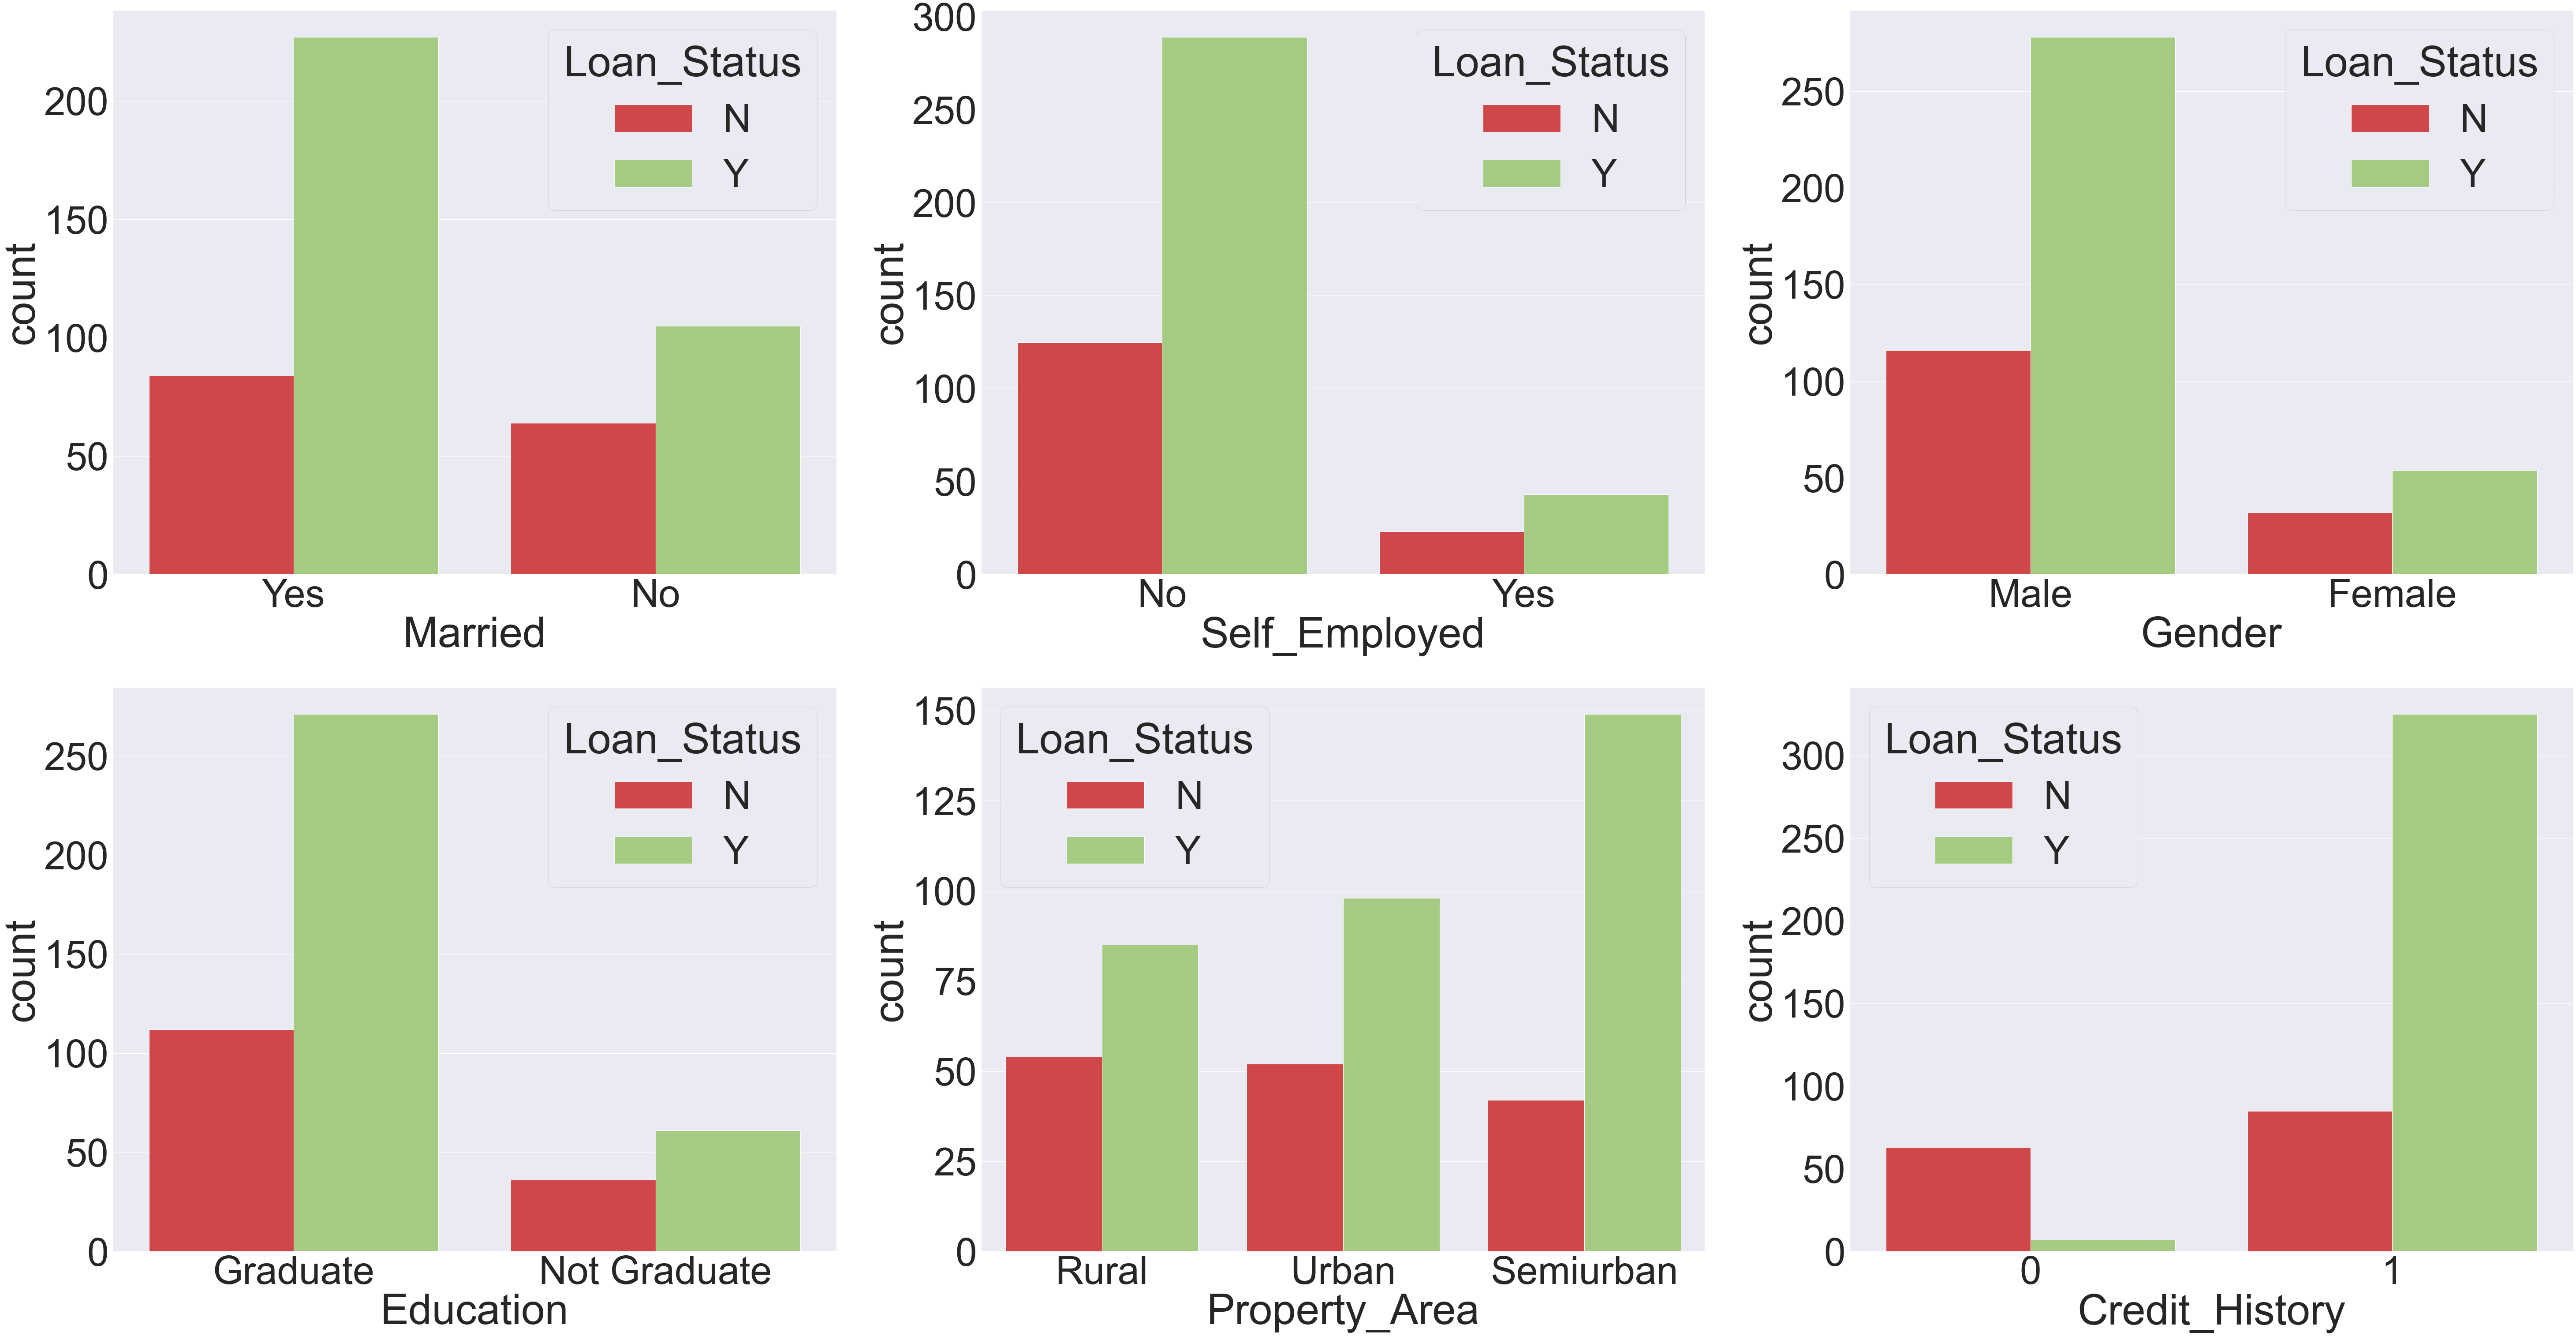

In [15]:
plt.figure(figsize = (100, 80))
sns.set(font_scale = 8)
plt.subplot(331)

sns.countplot(x = loan_df.select('Married').toPandas()['Married'], hue=loan_df.select('Loan_Status').toPandas()['Loan_Status']
             , palette=["#E63033","#A4D676"])

plt.subplot(332)
sns.countplot(x = loan_df.select('Self_Employed').toPandas()['Self_Employed'], hue=loan_df.select('Loan_Status').toPandas()['Loan_Status']
             , palette=["#E63033","#A4D676"])

plt.subplot(333)
sns.countplot(x = loan_df.select('Gender').toPandas()['Gender'], hue=loan_df.select('Loan_Status').toPandas()['Loan_Status']
             , palette=["#E63033","#A4D676"])

plt.subplot(334)
sns.countplot(x = loan_df.select('Education').toPandas()['Education'], hue=loan_df.select('Loan_Status').toPandas()['Loan_Status']
             , palette=["#E63033","#A4D676"])

plt.subplot(335)
sns.countplot(x = loan_df.select('Property_Area').toPandas()['Property_Area'], hue=loan_df.select('Loan_Status').toPandas()['Loan_Status']
             , palette=["#E63033","#A4D676"])

plt.subplot(336)
sns.countplot(x = loan_df.select('Credit_History').toPandas()['Credit_History'], hue=loan_df.select('Loan_Status').toPandas()['Loan_Status']
             , palette=["#E63033","#A4D676"])

In [16]:
loan_df.limit(10).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360,1,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267,360,1,Urban,Y
5,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95,360,1,Urban,Y
6,LP001014,Male,Yes,3,Graduate,No,3036,2504.0,158,360,0,Semiurban,N
7,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168,360,1,Urban,Y
8,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349,360,1,Semiurban,N
9,LP001024,Male,Yes,2,Graduate,No,3200,700.0,70,360,1,Urban,Y


### Format data and Transform dataframes
Dataframe will be verctorized

In [17]:
dependent_var = 'Loan_Status'
# Encode Loan_Status column to a column of label indices
indexer = StringIndexer(inputCol = dependent_var, outputCol='label')
# fits/trains on data that will produce a model . Transforme will read column and map it to a new one
indexed = indexer.fit(loan_df).transform(loan_df)
# Collect all the column names and store as a list
input_cols = indexed.columns
# Remove irrelevant columns such as loan_is and dependent variable
input_cols = input_cols[1:-2]

In [18]:
results = string_to_numeric_cols(indexed, input_cols)
indexed_df = results[0] # label column N =1.0 and Y = 0.0
numeric_cols = results[1]
string_cols = results[2]

In [19]:
indexed_df.limit(3).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,label,Gender_num,Married_num,Education_num,Self_Employed_num,Property_Area_num
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N,1.0,0.0,0.0,0.0,0.0,2.0
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y,0.0,0.0,0.0,0.0,1.0,1.0
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y,0.0,0.0,0.0,1.0,0.0,1.0


### Treating for Skewness and Outliers

In [20]:
# quantiles for numeric colums. Helps us determine the percent cutoff 
quantiles_dict = get_quantile_approx(numeric_cols, indexed_df)
indexed_df = fix_skewness(indexed_df, numeric_cols, quantiles_dict)

No skewness detected
Right/positive skewness of 6.895392015297443  was fixed on column  ApplicantIncome
Right/positive skewness of 5.863226080464341  was fixed on column  CoapplicantIncome
Right/positive skewness of 2.3540509424729  was fixed on column  LoanAmount
Left/negative skewness of -2.326411237343808  was fixed on column  Loan_Amount_Term
Left/negative skewness of -2.0069565427432434  was fixed on column  Credit_History


### Vectorize DataFrame and Scale data
* **VectorAssembler** is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees.
* We want to combine our independent variables into a single feature vector called features and use it to predict if a certain person will receive or not a loan.

In [21]:
features_lst = numeric_cols + string_cols
assembler = VectorAssembler(inputCols=features_lst, outputCol='features')
output = assembler.transform(indexed_df).select('features', 'label') # label N = 1.0 and Y = 0.0

In [22]:
# adjust column values to any value

final_data = scale_data(output)

final_data.show()

Features scaled to range: [0.000000, 1.000000]
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[0.33333333333333...|
|  0.0|(11,[1,3,4,5,9,10...|
|  0.0|[0.0,0.4518444741...|
|  0.0|(11,[1,3,4,5,7,10...|
|  0.0|[0.66666666666666...|
|  0.0|[0.0,0.4356541682...|
|  1.0|(11,[0,1,2,3,4],[...|
|  0.0|[0.66666666666666...|
|  1.0|(11,[0,1,2,3,4,5]...|
|  0.0|[0.66666666666666...|
|  0.0|[0.66666666666666...|
|  1.0|[0.0,0.3990208545...|
|  0.0|[0.66666666666666...|
|  0.0|(11,[1,3,4,5,7,10...|
|  1.0|(11,[1,3,4,6,7,10...|
|  1.0|(11,[1,3,4,5,8,10...|
|  1.0|(11,[1,3,4,8,10],...|
|  0.0|[0.33333333333333...|
|  1.0|(11,[1,2,3,4,8],[...|
|  0.0|(11,[1,3,4,5,9],[...|
+-----+--------------------+
only showing top 20 rows



### Train Data Set, Show Model's Accuracy and Confussion Matrix
* .addGrid() - Sets the given parameters in this grid to fixed values.
* .build() - Builds and returns all combinations of parameters specified by the param grid.

In [23]:
train,test = final_data.randomSplit([0.7,0.3])

In [25]:
Bin_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')
MC_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

In [26]:
lr_results = apply_logistic_regression(MC_evaluator,test) 
best_model, lr_best_model, predictions, accuracy = lr_results[0], lr_results[1], lr_results[2], lr_results[3]

print("Intercept: " + str(best_model.interceptVector))
print("Coefficients: \n" + str(best_model.coefficientMatrix))
print("Accuracy of Logistic Regression Model", accuracy)

featre_coef_df = map_features_coefficients(input_cols, best_model)

Intercept: [-0.025802785973507048]
Coefficients: 
DenseMatrix([[-0.23340897,  2.04771399,  0.97408379, -0.09015572,  2.99757676,
              -3.39768882,  0.27868302,  0.1410279 ,  0.93381198, -0.01344596,
               0.8806059 ]])
Accuracy of Logistic Regression Model 81.81818181818183


In [27]:
feature_coeff_df = map_features_coefficients(input_cols, best_model)
feature_coeff_df.show()

+-----------------+--------------------+
|          feature|         coefficient|
+-----------------+--------------------+
|           Gender| -0.2334089700148728|
|          Married|   2.047713991745898|
|       Dependents|  0.9740837886271756|
|        Education|-0.09015571942683641|
|    Self_Employed|  2.9975767562456084|
|  ApplicantIncome| -3.3976888217302856|
|CoapplicantIncome| 0.27868301575018833|
|       LoanAmount| 0.14102790430896867|
| Loan_Amount_Term|  0.9338119828461798|
|   Credit_History|-0.01344596408669...|
|    Property_Area|  0.8806058963701312|
+-----------------+--------------------+



In [28]:
predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(11,[0,1,2,3,4,5]...|[1.92716725814431...|[0.87293554655781...|       0.0|
|  0.0|(11,[0,1,2,3,4,5]...|[2.02901676891868...|[0.88381014825368...|       0.0|
|  0.0|(11,[0,1,2,3,4,5]...|[1.74183101170605...|[0.85091948867319...|       0.0|
|  0.0|(11,[0,1,2,3,4,5]...|[1.71499192436036...|[0.84748263931824...|       0.0|
|  0.0|(11,[0,1,2,3,4,5]...|[2.12801063745376...|[0.89359600343916...|       0.0|
|  0.0|(11,[0,1,3,4,5],[...|[2.54479276309422...|[0.92722290800567...|       0.0|
|  0.0|(11,[0,1,3,4,5],[...|[2.32322138310096...|[0.91078205077843...|       0.0|
|  0.0|(11,[0,1,3,4,5],[...|[2.65612093836055...|[0.93438725051009...|       0.0|
|  0.0|(11,[0,1,3,4,5],[...|[2.57310217349012...|[0.92911029076953...|       0.0|
|  0.0|(11,[0,1,

<AxesSubplot:>

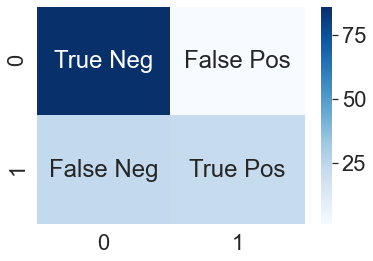

In [52]:
"""
    Create confusion matrix. 
    Convert predictions DF to an RDD. Use MulticlassMetrics .confusionMatrix() method.
    Turn results into an array to plot
"""
predictionAndLabels = predictions.select('prediction', 'label').rdd
metrics = MulticlassMetrics(predictionAndLabels)
cf_matrix = metrics.confusionMatrix().toArray()
sns.set(font_scale = 2)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')